# Aula 12 - Projeto Final

Nesse notebook tento fazer o pré-treino para uma tarefa de perguntas e respostas a partir de um dataset sintético gerado com o texto da Wikipedia. O objetivo, a partir disso, é transferir para a tarefa 1 do DocVQA.

### Sobre as imagens

Algumas características do dataset sintético gerado:
- Tamanho de imagem: 384x512
- Tamanho da sequência: de 64 a 128 palavras
- Tamanho da fonte: de 10 a 12
- Âncora de texto variável: sim, pode estar de 10 a `0.3*img_height` pixels do topo da imagem
- Mascaramento de 15\% dos tokens sendo eles (~ BERT):
    - 10\% não mascarados;
    - 80\% mascarados com [MASK];
    - 10\% trocados por uma palavra aleatória do vocabulário.

### Sobre a tarefa

A tarefa nesse caso são perguntas e respostas a partir dessas imagens sintéticas geradas. Aqui, faço perguntas que tem como objetivo o entendimento da linguagem ou do layout de alguma forma. Algumas delas são: 

- Quantos tokens mascarados tem?
- Quais são os tokens mascarados?
- Qual o primeiro/último token mascarado? 
- Qual a palavra antes/depois do primeiro/último token mascardo?
- Qual a sequência completa?

As respostas podem ser tanto números em formato de string, como sequências de texto.

### Sobre o treino

- Uso do t5-base (d_model = 768).
- Geração de embeddings da imagem por uma rede totalmente convolucional com ativações Swish redimensionadas para o tamanho `batch x 511 x 768`.
- Concatenação da pergunta junto aos embeddings de texto. As perguntas tem shape: `batch x 1 x 768`.
- Sequence length: 128
- Batch size: 2
- Grad accum: 8
- Tamanho dos conjuntos:
    - Treino: 1.000.000
    - Validação: 1.000
    - Teste: 1.000

## Importações e downloads

In [2]:
!nvidia-smi

Wed Dec 16 10:58:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!pip install ftfy datasets --quiet # pytorch-lightning transformers==3.5.1 --quiet

In [3]:
# !pip install neptune-client neptune-contrib[all] neptune-notebooks --quiet

In [4]:
neptune_params = {
    'api_key': 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZDYyNzIxNTYtMjFkMi00ODk3LTk3ZjQtOWRjYzQ4NjAxNjIzIn0=',
    'project_name': 'lupozz/ia376-aula12'
}

In [5]:
import os
import glob
import json
import random
import numpy as np
from PIL import Image
from imageio import imread
from collections import OrderedDict
from tqdm.notebook import tqdm
from itertools import product
from functools import partial
from copy import copy

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from pytorch_lightning.loggers.neptune import NeptuneLogger

from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration

import pytorch_lightning as pl
import transformers

print(f"""PyTorch Version: {torch.__version__}\n
          Lightning Version: {pl.__version__}\n
          Transformers Version: {transformers.__version__}""")

model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)

1.0.6 3.5.1


In [26]:
if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu" 
print(dev)
device = torch.device(dev)

cuda:0


In [7]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula7/arial.ttf .

Skipping existing item: file://./arial.ttf


In [7]:
from datasets import load_dataset

dataset = load_dataset('wikipedia', '20200501.en')


Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/f92599dfccab29832c442b82870fa8f6983e5b4ebbf5e6e2dcbe894e325339cd. Subsequent calls will reuse this data.


In [9]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['title', 'text'],
        num_rows: 6078422
    })
})


## Funções auxiliares

### Métricas

In [10]:
# Métricas feitas pelo professor de um notebook de outra aula

import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

### Geração das perguntas e respostas

In [34]:
def _find_word(text, mask, token_position):
    """Função auxiliar para encontrar a palavra antes/depois
    de um determinado token mascarado (token_position).
    
    """
    # return word after token position
    if token_position == 0:
        return text[token_position + 1]

    # return word before token position
    elif token_position == -1:
        return text[token_position - 1]
    else:
        raise Exception('Incorrect token position, it should be 0 or -1.')

def make_question_answer(original_text, mask, debug=False):
    """Construção das possibilidades de pergunta/resposta e escolha aleatória de uma delas.
    
    As tarefas de dividem em três objetivos principais e podem se mesclar:
        - OCR
        - Entendimento de texto
        - Entendimento de layout
    
    As respostas podem ser sequências de texto ou números em formato de string.
    
    """

    # Possibilidades de token/palavra questionada
    # Por enquanto só implementei iniciais/finais e relativos a essas posições.
    token_coord = ['first', 'last'] # random_token
    word_position_to_token = ['after', 'before'] # random_position
    word_position = ['first', 'last'] # random_word

    position_possibilities = [0, -1]
    
    word_pos = np.random.choice(position_possibilities)
    token_pos = np.random.choice(position_possibilities)

    # Geração das perguntas
    questions = {
        # Goal: OCR
        0: f'Which are all the masked tokens?', 

        # Goal: Text understanding
        1: f'What is the {token_coord[token_pos]} masked token?',

        # Goal: Layout/Text understanding
        2: f'What is the word {word_position_to_token[token_pos]} the {token_coord[token_pos]} covered token?',

        # Goal: Text understanding
        3: f'How many masked words are there?',

        # Goal: Text understanding
        4: f'How many words are in this sequence?',

        # Goal: Layout/text understanding
        5: f'What is the {word_position[word_pos]} word of the sentence?',

        # Goal: Text understanding + OCR
        6: f'What is the whole sentence?',

        # TODO
        # Goal: Layout understanding
        # f'Are there any images in this image?', # preciso colocar imagens aleatórias
        # Goal: Layout understanding
        # f'In which region of the page is the text mainly located?' # Top, bottom, half
    }

    # Pra conseguir usar as máscaras com o numpy
    original_text = np.array(original_text)

    # Geração das respostas
    answers = {0: ', '.join(original_text[mask == 1]), # All masked tokens
               1: str(original_text[mask == 1][token_pos]) if np.any(mask == 1) else 'None', # A single requested masked token
               2: _find_word(original_text, mask, token_pos), # Word before/after requested masked token
               3: str(len(mask[mask == 1])) if np.any(mask == 1) else '0', # Quantity of masked words
               4: str(len(original_text)), # Text length
               5: str(original_text[word_pos]), # First/last word of sentence
               6: ' '.join(original_text).replace('\n', ' '), # Whole sentence prediction
    }

    assert len(answers) == len(questions)

    # Sorteio de pergunta/resposta aleatória para essa amostra
    num = np.random.randint(0, high=len(questions), size=1)[0]

    if debug:
        print('Original text and mask: ', original_text, mask)
        print(json.dumps({q: a for q, a in list(zip(questions.values(), 
                                                    answers.values()))}, 
                         indent=2, ensure_ascii=False))

    return {'question': questions[num],
            'answer': answers[num]}

In [12]:
make_question_answer(np.array('oi como está você'.split()), np.array([0, 1, 0, 1]), debug=True)

Original text and mask:  ['oi' 'como' 'está' 'você'] [0 1 0 1]
{
  "Which are all the masked tokens?": "como, você",
  "What is the last masked token?": "você",
  "What is the word before the last covered token?": "está",
  "How many masked words are there?": "2",
  "How many words are in this sequence?": "4",
  "What is the first word of the sentence?": "oi",
  "What is the whole sentence?": "oi como está você"
}


{'question': 'What is the last masked token?', 'answer': 'você'}

### Mascaramento da sequência

In [13]:
def mask_sequence(text, tokenizer, mask_prob=0.15):
    """Mascaramento de uma sequência de texto.
    
    15% dos tokens do texto são trocados por máscaras. Desses 15%, 
    80% de fato viram máscaras, 10% viram um token aleatório e 10% 
    são inalterados. 
    
    """
    if isinstance(text, str):
        text = text.split(' ')

    if not isinstance(text, list):
        raise Exception('Text should be splitted into a list.')

    # 15% masked
    mask_placeholder = np.random.choice([0, 1], size=len(text), p=[1-mask_prob, mask_prob])

    # mask mutation: 0 = unaltered, 1 = mask, 2 = random token
    mask = np.where(mask_placeholder != 0, 
                    np.random.choice([0, 1, 2], 
                    size=len(mask_placeholder), 
                    p=[0.1, 0.8, 0.1]), 0)
    
    masked_idx = np.argwhere(mask == 1)

    vocab_size = tokenizer.vocab_size

    # Input random token
    text = np.where(mask == 2, tokenizer.decode(np.random.randint(0, vocab_size, size=1)), text)
    # Replace token with [MASK]
    text = np.where(mask == 1, '[MASK]', text)

    return text, mask

In [14]:
mask_sequence('hello how are you', tokenizer, mask_prob=0.50)

(array(['[MASK]', '[MASK]', 'are', 'you'], dtype='<U8'), array([1, 1, 0, 0]))

### Geração da imagem sintética com texto mascarado

In [35]:
# Modifiquei a partir do notebook da gabriela
import textwrap
import unicodedata
import ftfy

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

from imageio import imsave

def text_to_image_mask(text: str, max_width: int, max_height: int, tokenizer):
    """Geração de uma imagem sintética com texto mascarado.
    
    Modifiquei em cima da função do notebook da Gabriela.
    
    1. Corta o texto de 64 a 128 palavras.
    2. Limpa e mascara o texto.
    3. Gera a imagem com o texto mascarado.
    4. Adiciona ruído na imagem.
    
    """

    def _cut_text(text):
        # Tamanho de texto de 64 até 128 palavras
        text_size = np.random.randint(64, 128, size=1)[0]
        splitted_text = text.split()
        if text_size < len(splitted_text):
            text = ' '.join(splitted_text[:text_size])
        return text, text_size

    font_size = np.random.randint(10, 12)
    font = ImageFont.truetype("arial.ttf", font_size)
    
    image = Image.new('RGB', (max_width, max_height), (255, 255, 255))  # white background.
    d = ImageDraw.Draw(image)

    # Correção do texto, do notebook do Diedre
    text = ftfy.fix_text(text.encode('ascii', errors='ignore').decode())

    # Corta o texto
    splitted_text, text_size = _cut_text(text)
    original_text = copy(splitted_text)

    # Mascara a sequência
    masked_splitted_text, mask = mask_sequence(splitted_text, tokenizer)
    masked_text = ' '.join(masked_splitted_text)

    # Wrap da sequência
    wraps = textwrap.wrap(masked_text, width=int(max_width*0.95 // font_size*2))
        
    # Pontos âncoras do texto aleatórios
    left_border = np.random.randint(10, 14)
    top_border = np.random.randint(10, max_height*0.3)
    
    for col, wrap in enumerate(wraps): 
        d.text((left_border, top_border + 1.2 * font_size * col), 
               wrap, font=font, fill=(0, 0, 0))
        # Texto começa na posicão x=10, y=0.
            
    arr = np.array(image).astype(np.int)
    
    # Adição de ruído na imagem.
    arr += np.random.uniform(-30, 30, size=arr.shape).astype(np.int)
    
    return {
        'image':arr.clip(0, 255).astype(np.uint8),
        'text_size': text_size, # tamanho da sequência
        'text': text,           # texto original
        'splitted_cut_text': splitted_text, # texto cortado, em lista
        'mask': mask,           # máscara utilizada
        'masked_text': masked_text, # texto, em string, mascarado 
    }

In [16]:
output = text_to_image_mask(dataset['train'][0]['text'], 
                            max_width=384, 
                            max_height=512, 
                            tokenizer=tokenizer)

In [17]:
image = output['image']

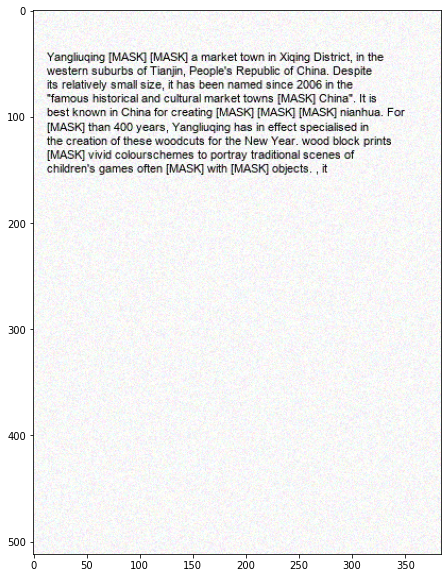

In [18]:
plt.figure(figsize=(15, 10))
plt.imshow(image)

In [19]:
output['mask'], output['splitted_cut_text']

(array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0]),
 'Yangliuqing () is a market town in Xiqing District, in the western suburbs of Tianjin, People\'s Republic of China. Despite its relatively small size, it has been named since 2006 in the "famous historical and cultural market towns in China". It is best known in China for creating nianhua or Yangliuqing nianhua. For more than 400 years, Yangliuqing has in effect specialised in the creation of these woodcuts for the New Year. wood block prints using vivid colourschemes to portray traditional scenes of children\'s games often interwoven with auspiciouse objects. , it')

In [20]:
make_question_answer(output['splitted_cut_text'].split(' '), output['mask'])

{'question': 'What is the word after the first covered token?', 'answer': '()'}

## Dataset

In [36]:
class FakeTextImageDataset(Dataset):
    def __init__(self, dataset, start, end, max_width, max_height, tokenizer, transform=None):
        self.dataset = dataset
        self.start = start
        self.end = end
        self.max_width = max_width
        self.max_height = max_height
        self.transform = transform
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        text = self.dataset[int(self.start + index)]['text']

        output = text_to_image_mask(text, 
                                    max_width=self.max_width, 
                                    max_height=self.max_height,
                                    tokenizer=self.tokenizer)
        image = output['image']
      
        qa = make_question_answer(output['splitted_cut_text'].split(' '), output['mask'])

        if self.transform:
            image = self.transform(image)

        return image, qa['question'], qa['answer']

    def __len__(self):
        return (self.end - self.start)
    
    def show_batch(self, size=1, figsize=(5, 10), display_patches=False):
        samples = np.random.randint(0, high=self.__len__(), size=size)
        for i, sample in enumerate(samples):
            image, question, answer = self.__getitem__(sample)

            print(f'{question} {answer}')

            plt.figure(figsize=figsize)
            plt.imshow((image.numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8))
            plt.xticks([])
            plt.yticks([])
            plt.show()

In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Dataset de treino vai até a amostra 1.000.000
# Validação e teste tem 1k amostras obtidas a partir desse valor
train_size = int(1e6)

train_ds = FakeTextImageDataset(dataset=dataset['train'],
                                start=0,
                                end=train_size,
                                max_width=384,
                                max_height=512,
                                tokenizer=tokenizer,
                                transform=transform)

val_ds = FakeTextImageDataset(dataset=dataset['train'],
                              start=train_size,
                              end=train_size + 1000,
                              max_width=384,
                              max_height=512,
                              tokenizer=tokenizer,
                              transform=transform)

test_ds = FakeTextImageDataset(dataset=dataset['train'],
                               start=train_size + 1000,
                               end=train_size + 2000,
                               max_width=384,
                               max_height=512,
                               tokenizer=tokenizer,
                               transform=transform)

In [23]:
image, question, answer = val_ds[123]

In [24]:
image.shape

torch.Size([3, 512, 384])

How many words are in this sequence? 22


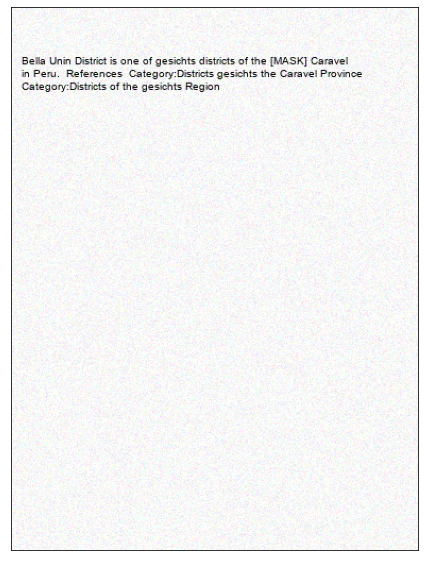

In [25]:
val_ds.show_batch(figsize=(15, 10))

## Classes do Modelo

### Função de ativação Swish

In [27]:
# https://medium.com/the-artificial-impostor/more-memory-efficient-swish-activation-function-e07c22c12a76

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
    
class CustomSwish(nn.Module):
    def forward(self, input_tensor):
        return Swish.apply(input_tensor)

def print_parameter_count(model):
    print("# of parameters: {:,d}".format(
        np.sum(list(p.numel() for p in model.parameters()))))
    print("# of trainable parameters: {:,d}".format(
        np.sum(list(p.numel() for p in model.parameters() if p.requires_grad))))

### Modelo

In [28]:
class T5Finetuner(pl.LightningModule):

    def __init__(self, train_dataloader, val_dataloader, test_dataloader, tokenizer, params):
        super(T5Finetuner, self).__init__()

        self.params = params
        
        self._train_dataloader = train_dataloader
        self._val_dataloader   = val_dataloader
        self._test_dataloader  = test_dataloader

        self.t5 = T5ForConditionalGeneration.from_pretrained(params['model_name'])

        # Para conversão dos patches em embeddings (512, 511)
        self.conv_bridge = torch.nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1)),
            ('maxpool1', torch.nn.MaxPool2d(2)),
            ('relu1', torch.nn.ReLU()),
            ('batch_norm1', torch.nn.BatchNorm2d(128)),
            ('conv2', torch.nn.Conv2d(128, 511, kernel_size=3, stride=2, padding=1)),
            ('maxpool2', torch.nn.MaxPool2d(2)),
            ('relu2', torch.nn.ReLU()),
            ('batch_norm2', torch.nn.BatchNorm2d(511)),
        ]))

        self.tokenizer = tokenizer
        self.learning_rate = params['learning_rate']

    def _embeds_forward(self, img):

        features = img
        
        # Transform patches to input them in the T5 model
        features = self.conv_bridge(features)
        
        # Reshape the output to the 2D format of the tranformer.
        # Shape: (batch, 512, 512)
        inputs = features \
            .permute(0, 2, 3, 1) \
            .reshape(features.shape[0], -1, self.t5.config.d_model)
        
        return inputs

    
    def _generate_tokens(self, embedding, only_decoder=True):
        ''' Peguei do código do Diedre

        Adaptação de código da aula 10 do semestre passado. Usa features para gerar frases com T5.

        A forma que faz mais sentido pra mim é usar encoder_outputs como sendo as features e deixar o t5 usar
        embeddings de texto padrão na decodificação. Não sei se está 100% correto.

        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((embedding.shape[0], 1),
                                 self.t5.config.decoder_start_token_id,
                                 dtype=torch.long).to(embedding.device)

        if not only_decoder:
            # Passa os embeddings pelo encoder
            encoder_hidden_states = self.t5.get_encoder()(inputs_embeds=embedding)

        for step in range(max_length-1):
            if not only_decoder:
                # Full T5, usa os embeddings computados pelo encoder na decodificação
                logits = self.t5(decoder_input_ids=decoded_ids,
                                 encoder_outputs=encoder_hidden_states)[0]
            else:
                logits = self.t5(decoder_input_ids=decoded_ids,
                                 encoder_outputs=(embedding,))[0]
                
            next_token_logits = logits[:, -1, :]

            # Greedy decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids


    def forward(self, batch):
        images, questions, answers, encoded_questions, encoded_answers = batch

        image_embeddings = self._embeds_forward(images)

        # Perguntas tokenizadas
        encoded_questions = encoded_questions.unsqueeze(1)
        
        # Concatenação com os embeddings da imagem
        embeddings = torch.cat((image_embeddings.float(), encoded_questions.float()), dim=1).float()

        if self.training:
            outputs = self.t5(encoder_outputs=(embeddings,), 
                              labels=encoded_answers,
                              return_dict=True)
            
            return outputs.loss
        else:
            return self._generate_tokens(image_embeddings, only_decoder=True)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        answers = batch[2]
        return {"pred": decoded_pred, "target": answers}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        answers = batch[2]
        return {"pred": decoded_pred, "target": answers}

    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.learning_rate, eps=1e-08)

    """
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.learning_rate, eps=1e-08)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler, 
            'reduce_on_plateau': True,
            'monitor': 'loss_epoch'
        }
        return [optimizer], [scheduler]   
    """

    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader

    def test_dataloader(self):
        return self._test_dataloader

### Collate

In [38]:
def collate_fn(batch, params={'seq_len_questions': 256}):
    """ Tokenização do batch e alguns pré-processamentos.
    
    """
    imgs = torch.as_tensor(torch.stack([sample[0] for sample in batch]))
    questions = [sample[1] for sample in batch]
    answers = [sample[2] for sample in batch]
    
    # Fiz o pad separado pra limitar o seq_len em 128
    # Mas o tamanho precisa ser 768 pra concatenar com os embeddings das imagens.
    questions_pad = torch.zeros((len(questions), 
                                 params['seq_len_questions']-params['seq_len']),
                               dtype=torch.int64)
    answers_pad = torch.zeros((len(answers), 
                               params['seq_len_questions']-params['seq_len']),
                             dtype=torch.int64)
    
    # Dict com 'input_ids' e 'attention_mask'
    encoded_questions = tokenizer.batch_encode_plus(questions, 
                                          padding='max_length',
                                          truncation=True,
                                          max_length=params['seq_len'],
                                          return_tensors='pt')['input_ids']
    
    encoded_answers = tokenizer.batch_encode_plus(answers, 
                                                  padding='max_length',
                                                  truncation=True,
                                                  max_length=params['seq_len'],
                                                  return_tensors='pt')['input_ids']

    encoded_questions = torch.cat((encoded_questions, questions_pad), dim=1)
    encoded_answers = torch.cat((encoded_answers, answers_pad), dim=1)
    
    return imgs, questions, answers, encoded_questions, encoded_answers

## Parâmetros e Dataloaders

In [39]:
params = {
    'model_name': model_name, # definido lá no topo do código
    'batch_size_train': 2,
    'batch_size_eval': 2,
    'num_workers': 8,
    'seq_len': 128,           # seq len do texto
    'seq_len_questions': 768, # tamanho que as perguntas precisam ter para a concatenação == d_model
    'learning_rate': 5e-4,
    'max_epochs': 30,
    'patience': 3,
    'monitor_variable': 'val_f1', # Critério do early stopping,
}

_collate = partial(collate_fn, params=params)

train_loader = DataLoader(train_ds,
                          batch_size=params['batch_size_train'],
                          num_workers=params['num_workers'], 
                          collate_fn=_collate)

val_loader = DataLoader(val_ds,
                        batch_size=params['batch_size_eval'],
                        num_workers=params['num_workers'],
                        collate_fn=_collate)

test_loader = DataLoader(test_ds,
                         batch_size=params['batch_size_eval'],
                         num_workers=params['num_workers'],
                         collate_fn=_collate)

## Teste preliminar

Para debug.

In [31]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    tokenizer=tokenizer,
                    params=params)

trainer = pl.Trainer(gpus=1, 
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     fast_dev_run=True)
trainer.fit(model)
trainer.test(model)
del model  # Para não ter estouro de mémoria da GPU

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name        | Type                       | Params
-----------------------------------------------------------
0 | t5          | T5ForConditionalGeneration | 222 M 
1 | conv_bridge | Sequential                 | 594 K 
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. C


Sample Target: Alessandra Scala (14751506) was an Italian poet and a Greek scholar.  Biography  She was born in 1475, the fifth daughter of the chancellor of Florence, Bartolomeo Scala. Scala studied under Janus Lascaris and Angelo Politian, and corresponded with Cassandra Fedele.  In 1494, she married Greek poet and soldier Michael Tarchaniota Marullus (1458  1500), six years later Marullus died, Scala then entered the Florentine convent of San Pier Maggiore. She died there in 1506.  References  Category:Italian women poets Category:1475 births Category:1506 deaths
Prediction: <extra_id_0>. There are no<extra_id_1>. There are no<extra_id_2>. There are no<extra_id_3>. There are no<extra_id_4>. There are no<extra_id_5>.<extra_id_6>.<extra_id_7>.<extra_id_8>.<extra_id_9>.<extra_id_10>.<extra_id_11>.<extra_id_12>.<extra_id_13>.<extra_id_14>.<extra_id_15>.<extra_id_16>.<extra_id_17>.<extra_id_18>.<extra_id_19>..<extra_id_20>..<extra_id_21>..<extra_id_22>..<extra_id_23>..<extra_id_24>..<ex

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Sample Target: 113
Prediction: <extra_id_0>. There are no<extra_id_1>. There are no<extra_id_2>. There are no<extra_id_3>. There are no<extra_id_4>. There are no<extra_id_5>.<extra_id_6>.<extra_id_7>.<extra_id_8>.<extra_id_9>.<extra_id_10>.<extra_id_11>.<extra_id_12>.<extra_id_13>.<extra_id_14>.<extra_id_15>.<extra_id_16>.<extra_id_17>.<extra_id_18>.<extra_id_19>..<extra_id_20>..<extra_id_21>..<extra_id_22>..<extra_id_23>..<extra_id_24>..<extra_id_25>..<extra_id_26>..<extra_id_27>.................. 

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_exact': 0.0, 'test_f1': 0.0}
--------------------------------------------------------------------------------



## Treino rápido para ver se a loss está reduzindo

In [31]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=None,
                    tokenizer=tokenizer,
                    params=params)

trainer = pl.Trainer(gpus=1, 
                     max_epochs=30,
                     check_val_every_n_epoch=5,
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     overfit_batches=2)
trainer.fit(model)
del model, trainer  # Para não ter estouro de mémoria da GPU

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                       | Params
-----------------------------------------------------------
0 | t5          | T5ForConditionalGeneration | 222 M 
1 | conv_bridge | Sequential                 | 594 K 



Sample Target: St.
Prediction: <extra_id_0> to create a sense of<extra_id_1> to create<extra_id_2> to create<extra_id_3> or<extra_id_4> a<extra_id_5> or<extra_id_6> powers<extra_id_7> powers<extra_id_8> powers<extra_id_9> powers<extra_id_10> powers were enacted<extra_id_11> powers were enacted<extra_id_12> powers were enacted<extra_id_13> powers were enacted<extra_id_14> powers were enacted<extra_id_15> powers were enacted<extra_id_16> powers were enacted<extra_id_17> powers were enacted<extra_id_18> powers were enacted<extra_id_19> powers were<extra_id_20> powers were<extra_id_21>,<extra_id_22> or<extra_id_23> powers were<extra_id_24> powers were<extra_id_25> powers were<extra_id_26> powers were<extra_id_27> powers were enacted, as were




Sample Target: ()
Prediction: YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY




Sample Target: ()
Prediction: YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY




Sample Target: St.
Prediction: B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B




Sample Target: ()
Prediction: S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S S




Sample Target: may
Prediction: mar                                                                                                      




Sample Target: Orana
Prediction: 




# Treino

In [ ]:
# Checkpoint the best model.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    prefix="vqa-synthetic",
    filepath="logs/{epoch}-{val_f1:.2f}", 
    monitor="val_f1", 
    mode="max",
)

callbacks = [pl.callbacks.EarlyStopping(monitor=params['monitor_variable'], 
                                        patience=params["patience"], 
                                        mode='max')]

neptune_logger = NeptuneLogger(
    api_key=neptune_params['api_key'],
    project_name=neptune_params['project_name'],
    params=params)

trainer = pl.Trainer(gpus=1,
                     precision=32,
                     log_gpu_memory=True,
                     max_epochs=params['max_epochs'],
                     # check_val_every_n_epoch=1,
                     accumulate_grad_batches=8,
                     val_check_interval=5000,
                     profiler=True,
                     logger=neptune_logger,
                     callbacks=callbacks,
                     checkpoint_callback=checkpoint_callback)

model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    tokenizer=tokenizer,
                    params=params)

trainer.fit(model)

https://ui.neptune.ai/lupozz/ia376-aula12/e/IAAUL-17


NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                       | Params
-----------------------------------------------------------
0 | t5          | T5ForConditionalGeneration | 222 M 
1 | conv_bridge | Sequential                 | 594 K 



Sample Target: Cathedral
Prediction: <extra_id_0> to create a sense of<extra_id_1> to create<extra_id_2> the<extra_id_3> powers<extra_id_4> the<extra_id_5> the powers that be<extra_id_6> the powers that be<extra_id_7> the powers that be<extra_id_8> the<extra_id_9> the<extra_id_10> t<extra_id_11> t<extra_id_12> the<extra_id_13> t<extra_id_14> t<extra_id_15> t<extra_id_16> t<extra_id_17> t<extra_id_18> t<extra_id_19> t<extra_id_20> t<extra_id_21> t<extra_id_22> the power to cut through the<extra_id_23>....and<extra_id_24>..<extra_id_25>..and<extra_id_26>..and<extra_id_27>..and a few others..and a few others..and a



Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAAUL-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 3e70881c-3089-440d-9ed1-c1fd3360b2

In [ ]:
# Guardando aqui no fim do código, pode ser útil

import gc
del model, trainer
gc.collect()
torch.cuda.memory_allocated() / 1024

# Conclusões

- Não tive tanto tempo de treino nessas duas semanas pois estava lidando com alguns erros de código e me acertando com rodar o jupyter de dentro de um docker de dentro de uma vm. Para quem se interessar, deixei [neste repo](https://github.com/luizapozzobon/experiments-env) as instruções e o dockerfile para fazer isso.
- Nesse notebook tentei colocar a pergunta junto aos embeddings da imagem, mas não tenho certeza se foi a melhor das abordagens. Do jeito que fiz, a sequência máxima é 128, mas preciso colocar pad até 768 isso ocasiona a presença de muitos tokens vazios.
- Gostaria de ter adicionado algumas tarefas mais específicas de layout, conforme deixei comentado na função que as gera.